In [1]:
import requests
import time
import image_helpers
from transformers import AutoModel, AutoFeatureExtractor
from datasets import load_dataset
import torchvision.transforms as T
import torch
import random
import numpy as np
import os


c:\Users\josie\Documents\dallESpeckleMap\AI_image_analyzer\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_directory = "C:/Users/josie/OneDrive - Chalmers/Documents/Speckle hackathon/data/gold/"

In [3]:
## Download all thumbnails from Poly Haven texture asset library

# url = "https://api.polyhaven.com/assets?t=textures"
# headers = {
#     "Content-type": "application/json"
# }

# response = requests.get(url, headers=headers)

# all_textures = response.json()

# for each_texture in list(all_textures)[:1]:
#     image_url = all_textures[each_texture]['thumbnail_url']
#     image_filename = root_directory + "train/unlabeled/" + each_texture + ".png"
#     response = requests.get(image_url)
#     if response.status_code == 200:
#         # Write the image content to the file
#         with open(image_filename, 'wb') as f:
#             f.write(response.content)
#     time.sleep(1)

# # Convert images to grayscale
# thumbnails = root_directory + "train/unlabeled/"

# image_helpers.convert_images_to_grayscale(thumbnails)

In [4]:
## Build reference embedding database

dataset = load_dataset("imagefolder", data_dir=root_directory, split="train")
dataset = dataset.add_column("filenames", os.listdir(root_directory + 'train/unlabeled/'))

model_ckpt = "nateraw/vit-base-beans" ## FIND DIFFERENT MODEL

extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

seed = 42
candidate_dataset = dataset.shuffle(seed=seed)

transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

# Here, we map embedding extraction utility on our subset of candidate images.
batch_size = 24
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = image_helpers.extract_embeddings(transformation_chain, model.to(device))
candidate_subset_emb = candidate_dataset.map(extract_fn, batched=True, batch_size=24)

candidate_ids = []

for id in range(len(candidate_subset_emb)):
    
    # Create a unique indentifier.
    entry = str(id) + "_" + str(random.random()).split('.')[1]

    candidate_ids.append(entry)

all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)

# Save embeddings

c:\Users\josie\Documents\dallESpeckleMap\AI_image_analyzer\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\josie\Documents\dallESpeckleMap\AI_image_analyzer\.venv\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 491/491 [00:05<00:00, 95.32 examples/s] 


In [5]:
## Process test images

test_directory = root_directory + "test/unlabeled/"

# Convert images to grayscale
image_helpers.convert_images_to_grayscale(test_directory)

# Crop to the largest contour
# Alternatives to try:
    # Find the largest non-white area with the maximum y distance and maximum x distance

image_helpers.crop_center_largest_contour(test_directory)

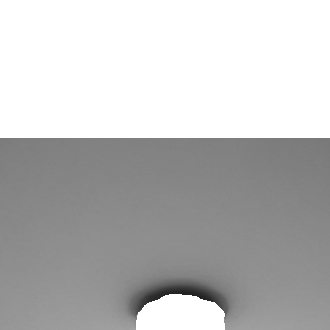

In [6]:
## Test process

## Query materials

intervention_directory = "C:/Users/josie/OneDrive - Chalmers/Documents/Speckle hackathon/data/temp_test_image/"
test_ds = load_dataset("imagefolder", data_dir=intervention_directory)
query_image = test_ds['train'][1]['image']
# test_ds = load_dataset("imagefolder", data_dir=root_directory, split="test")
# random_index = np.random.choice(len(test_ds))
# query_image = test_ds[random_index]["image"]
query_image

leather_white.png
clay_floor_001.png
leather_red_03.png
painted_plaster_wall.png
scuffed_cement.png


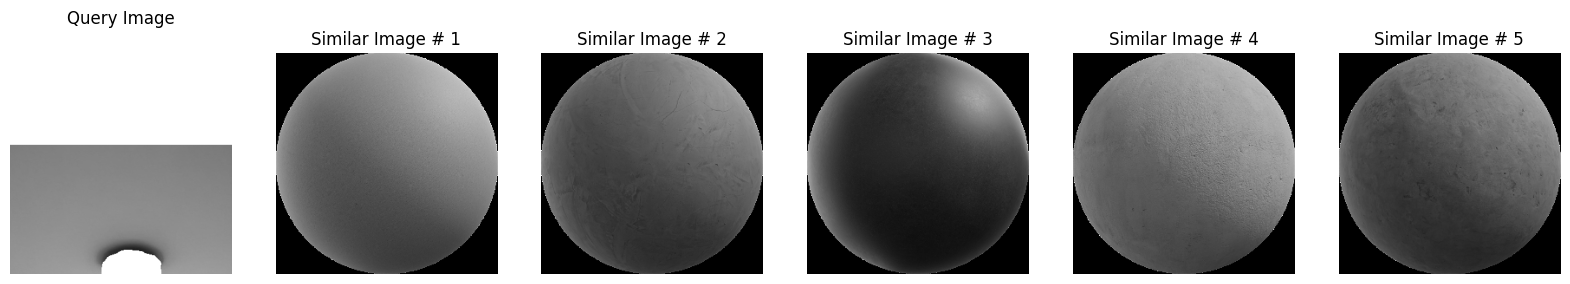

In [15]:
sim_ids = image_helpers.fetch_similar(query_image, transformation_chain, device, model, all_candidate_embeddings, candidate_ids)

images = []

for id in sim_ids:
    images.append(candidate_subset_emb[id]["image"])
    print(candidate_subset_emb[id]['filenames'])

images.insert(0, query_image)
image_helpers.plot_images(images)